In [15]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from tqdm import tqdm
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [17]:
!pip install torch-summary
!pip install tqdm

In [19]:
class ImagesDataProcess(Dataset):
    def __init__(self,csv_file,root_dir,tranform=None):
        self.annotation=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.tranform=tranform
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        img_path=os.path.join(self.root_dir,self.annotation.iloc[index,0])
        image=io.imread(img_path)
        y_label=torch.tensor(int(self.annotation.iloc[index,1]))
        
        if self.tranform:
            image=self.tranform(image)
        return (image,y_label)

In [21]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 10
root_dir_path='/Users/shreyanshsingh/Documents/KAGGLE PROJECTS/Cats&Dog_Classification/archive/cat_dog'
csv_file_path='/Users/shreyanshsingh/Documents/KAGGLE PROJECTS/Cats&Dog_Classification/archive/cat_dog.csv'


In [23]:
my_transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
#         transforms.ColorJitter(brightness=0,contrast=0,saturation=0,hue=0),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.05),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomCrop((224,224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5,0.5,0.5],std=[1.0,1.0,1.0])
    ]
) 

In [25]:
dataset=ImagesDataProcess(
    csv_file=csv_file_path,
    root_dir=root_dir_path,
    tranform=my_transform
)

In [27]:
train_set, test_set = torch.utils.data.random_split(dataset, [20000, 5000])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [29]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break

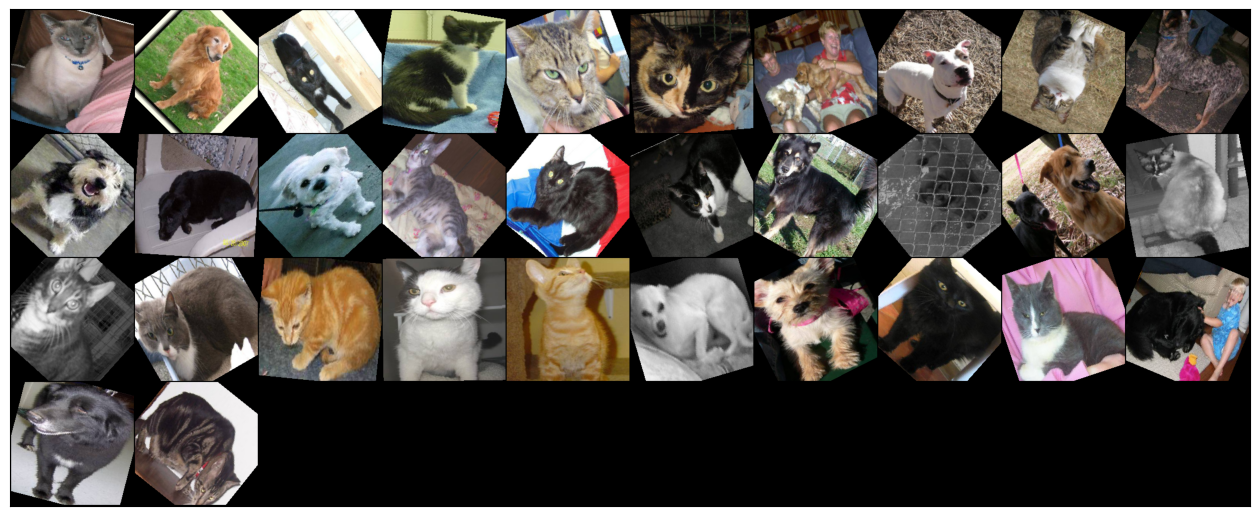

In [31]:
show_batch(train_loader)

In [33]:
class Conv_block(nn.Module):
    def __init__(self,in_channel,out_channel,**kwargs):
        super(Conv_block,self).__init__()
        
        self.network=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,**kwargs),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
    def forward(self,x):
        return self.network(x)

In [35]:
class Inception_block(nn.Module):
    def __init__(
        self,in_channel,out_1x1,red_3x3,out_3x3,red_5x5,out_5x5,out_pool_3x3):
        
        super(Inception_block,self).__init__()
        
        self.branch_1=nn.Sequential(Conv_block(in_channel,out_1x1,kernel_size=1))
        
        self.branch_2=nn.Sequential(
            Conv_block(in_channel,red_3x3,kernel_size=1),
            Conv_block(red_3x3,out_3x3,kernel_size=3,padding=1)
        )
        
        self.branch_3=nn.Sequential(
            Conv_block(in_channel,red_5x5,kernel_size=1),
            Conv_block(red_5x5,out_5x5,kernel_size=5,padding=2)
        )
        
        self.branch_4=nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            Conv_block(in_channel,out_pool_3x3,kernel_size=1)
        )
        
    def forward(self,x):
        return torch.cat(
            [self.branch_1(x),
             self.branch_2(x),
             self.branch_3(x),
             self.branch_4(x)],
            1
        )

In [37]:
class GoogleNet(nn.Module):    
    def __init__(self,in_channel,out_channel):
        super(GoogleNet,self).__init__()
        
        self.conv_1=Conv_block(in_channel,64,kernel_size=7,padding=3,stride=2)
        
        self.pool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.conv_2=Conv_block(64,192,kernel_size=3,padding=1,stride=1)
        
        self.inception_3a=Inception_block(192,64,96,128,16,32,32)
        self.inception_3b=Inception_block(256,128,128,192,32,96,64)
        
        self.inception_4a=Inception_block(480,192,96,208,16,48,64)
        self.inception_4b=Inception_block(512,160,112,224,24,64,64)
        self.inception_4c=Inception_block(512,128,128,256,24,64,64)
        self.inception_4d=Inception_block(512,112,144,288,32,64,64)
        self.inception_4e=Inception_block(528,256,160,320,32,128,128)
        
        self.inception_5a=Inception_block(832,256,160,320,32,128,128)
        self.inception_5b=Inception_block(832,384,192,384,48,128,128)
        
        self.avgPool=nn.AvgPool2d(kernel_size=7,stride=1)
        
        self.drop=nn.Dropout(p=0.4)
        
        self.fc=nn.Linear(1024,out_channel)
        
        
    def forward(self,x):
        x=self.conv_1(x)
        
        x=self.pool(x)
        
        x=self.conv_2(x)
        
        x=self.pool(x)
        
        x=self.inception_3a(x)
        x=self.inception_3b(x)
        
        x=self.pool(x)
        
        x=self.inception_4a(x)
        x=self.inception_4b(x)
        x=self.inception_4c(x)
        x=self.inception_4d(x)
        x=self.inception_4e(x)
        
        x=self.pool(x)
        
        x=self.inception_5a(x)
        x=self.inception_5b(x)
        
        
        
        x=self.avgPool(x)
        
        x=x.reshape(x.shape[0],-1)

        
        x=self.drop(x)
        
        x=self.fc(x)
        
        return x
        

In [39]:
model=GoogleNet(in_channel=3,out_channel=10)


In [41]:
from torchsummary import summary
x=torch.rand(3,3,224,224)
print(summary(model,x,verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv_block: 1-1                        [-1, 64, 112, 112]        --
|    └─Sequential: 2-1                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 112, 112]        9,472
|    |    └─BatchNorm2d: 3-2             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-3                    [-1, 64, 112, 112]        --
├─MaxPool2d: 1-2                         [-1, 64, 56, 56]          --
├─Conv_block: 1-3                        [-1, 192, 56, 56]         --
|    └─Sequential: 2-2                   [-1, 192, 56, 56]         --
|    |    └─Conv2d: 3-4                  [-1, 192, 56, 56]         110,784
|    |    └─BatchNorm2d: 3-5             [-1, 192, 56, 56]         384
|    |    └─ReLU: 3-6                    [-1, 192, 56, 56]         --
├─MaxPool2d: 1-4                         [-1, 192, 28, 28]         --
├─Inception_block: 1-5                   [-1, 256, 28, 28]         --
|    

In [43]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
device=get_default_device()
device

device(type='cpu')

In [49]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
to_device(model, device);

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        # Get data to cuda if possible
        data = data
        targets = targets
        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")
%time


625it [05:56,  1.75it/s]


Cost at epoch 0 is 0.642488487291336


625it [03:32,  2.95it/s]


Cost at epoch 1 is 0.4922340307712555


625it [03:34,  2.92it/s]


Cost at epoch 2 is 0.38937685570716857


625it [03:34,  2.92it/s]


Cost at epoch 3 is 0.32742060328722


625it [03:34,  2.92it/s]


Cost at epoch 4 is 0.27766258444786074


625it [03:35,  2.90it/s]


Cost at epoch 5 is 0.25084809231758115


625it [03:37,  2.88it/s]


Cost at epoch 6 is 0.22953684628605842


625it [03:36,  2.89it/s]


Cost at epoch 7 is 0.21820357459783554


625it [03:39,  2.85it/s]


Cost at epoch 8 is 0.20192167811989783


625it [03:37,  2.87it/s]

Cost at epoch 9 is 0.19179831792712213
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs


In [20]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x
            y = y
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [21]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Checking accuracy on Training Set


100%|██████████| 625/625 [02:41<00:00,  3.86it/s]


Got 18657 / 20000 with accuracy 93.28
Checking accuracy on Test Set


100%|██████████| 157/157 [01:21<00:00,  1.92it/s]

Got 4626 / 5000 with accuracy 92.52
